# 🧩 Análisis de redes con Python
**Workshop 4**

### *Creado por: Megan García Antivar* 🌱

En matemáticas y en ciencias de la computación, la teoría de grafos o análisis de redes estudia las propiedades de los grafos
(también llamadas gráficas). Un grafo es un conjunto, no vacío, de objetos llamados **vértices** (o nodos) y una selección de pares de vértices,
llamados aristas (edges en inglés) que pueden ser orientados o no. Típicamente, un grafo se representa mediante una serie de puntos (los vértices)
conectados por **líneas** (las aristas).

Tanto los nodos como las aristas pueden contener metadatos en forma de pares clave-valor. Por ejemplo, en una red social los nodos «Hugo» y “Eric” pueden tener cada uno un atributo {"edad 25 }, mientras que la arista entre ellos podría almacenar `{ «first_met»: «2016-05-21» }`.

**¿Por qué modelar los datos como un gráfo?** 🥸

Representar los datos como un grafo permite abordar cuestiones que son difíciles de responder con tablas convencionales, como:

- ¿Quiénes son las personas influyentes clave dentro de una comunidad en línea?
- ¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?
- ¿Existen clusters o comunidades densamente conectadas en la red?
- Encontrar el camino más corto utilizando una red de calles específica es un problema SIG común que tiene muchas aplicaciones prácticas. Por ejemplo, la navegación, una de esas aplicaciones para las que se utilizan algoritmos de encaminamiento para encontrar la ruta óptima entre dos o más puntos.

Examinando la estructura de un grafo podemos calcular métricas a nivel de nodo (por ejemplo, la centralidad), identificar puentes críticos o detectar agrupaciones naturales de comunidades.

## 1. Obtener una red ruteable

El paquete NetworkX ofrece varias herramientas para analizar redes e implementa distintos algoritmos de encaminamiento, como el de Dijkstra o el A*. Ambos se utilizan habitualmente para encontrar los caminos más cortos a lo largo de las redes de transporte.

Para poder realizar análisis de redes es necesario, por supuesto, disponer de una red que se utilice para los análisis. El paquete OSMnx nos permite recuperar redes ruteables de OpenStreetMap para varios modos de transporte (a pie, en bicicleta y en coche). OSMnx también envuelve algunas de las funcionalidades de NetworkX de una manera conveniente para su uso en los datos de OpenStreetMap.

En la siguiente sección, usaremos OSMnx para encontrar el camino más corto entre dos puntos basado en caminos ciclables. Con sólo pequeñas modificaciones, podemos repetir el análisis para la red de calles peatonales.

In [92]:
# Descargar librería para trabajar OpenStreetMap

!pip install osmnx

### 📦 ¿Qué es `osmnx`?

`osmnx` es una biblioteca de Python muy potente que permite trabajar con datos geoespaciales y de redes urbanas usando OpenStreetMap. A continuación se resumen sus principales funcionalidades:

| Funcionalidad | Descripción |
|---------------|-------------|
| Descargar datos | Permite obtener redes de calles, caminos y otros elementos desde OpenStreetMap. |
| Convertir en grafos | Convierte los datos en grafos de `networkx` o en `GeoDataFrames` para análisis geoespacial. |
| Análisis de redes | Calcula rutas más cortas, medidas de centralidad, accesibilidad, conectividad, etc. |
| Visualización | Genera mapas y gráficos de la red, rutas, puntos de interés, etc. |
| Trabajar con lugares reales | Permite usar nombres de lugares (ej. "Bogotá", "Madrid") o polígonos personalizados como entrada. |

### A. Importar librerías 📚

In [56]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from shapely.geometry import Polygon, MultiPolygon

### 1.1. Análisis de redes en Teusaquillo

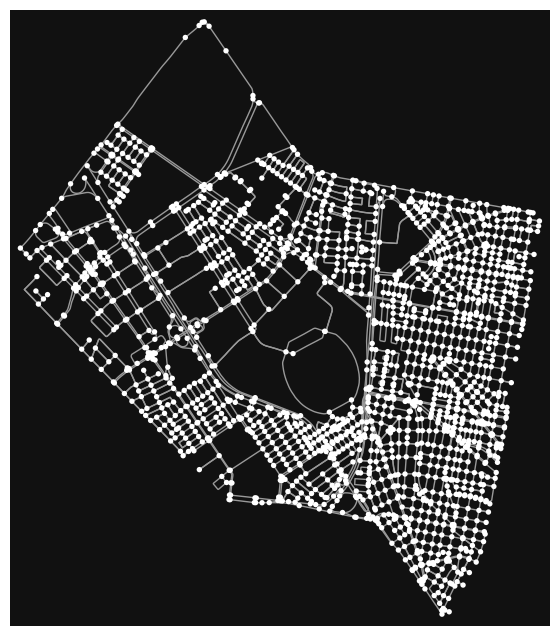

In [3]:
PLACE_NAME = "Teusaquillo, Bogotá, Colombia"
graph = ox.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)
figure, ax = ox.plot_graph(graph)

### 📍 Expandir el área de análisis

A veces, las rutas más cortas pueden extenderse levemente más allá de los límites administrativos de un barrio. Para evitar rutas truncadas o sin conexión en los bordes de la red, es útil cargar un área más grande a partir de un punto central o un buffer sobre el límite administrativo de interés, para este caso, se aplicó un buffer de un kilómetros.

<Axes: >

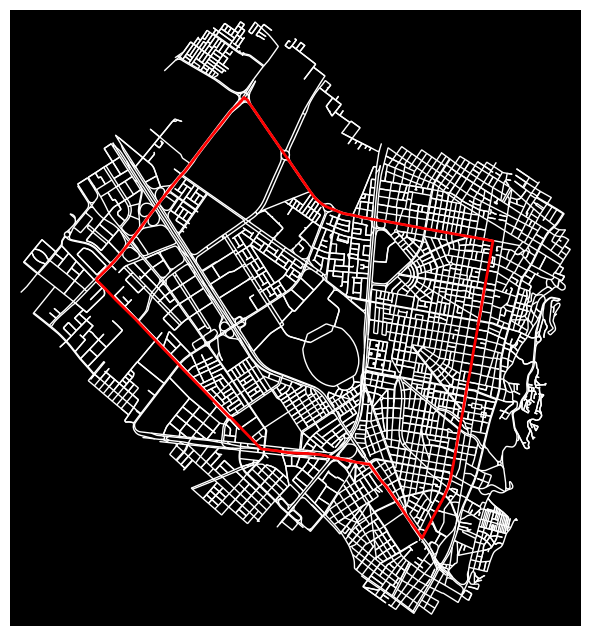

In [9]:
# Obtener el polígono de Teusaquillo
gdf = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia")

# Proyectar para poder usar metros
gdf = gdf.to_crs(epsg=3857)

# Aplicar buffer (ej. 1000 metros)
gdf["geometry"] = gdf.buffer(1000)

# Volver a coordenadas geográficas
gdf = gdf.to_crs(epsg=4326)

# Descargar la red expandida con forma de la localidad + buffer
graph = ox.graph_from_polygon(gdf.geometry[0], network_type="drive")

# Visualizar
fig, ax = ox.plot_graph(graph, show=False, close=False, node_size=0.5, edge_color="white", bgcolor="black")
ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia").plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

### 1.2. ⏱️ Incorporación de velocidades estimadas y tiempos de viaje

El análisis de redes viales en entornos urbanos no solo depende de la distancia física entre dos puntos, sino también del tiempo que toma recorrer dichas distancias. En este sentido, el uso del parámetro por defecto `weight="length"` en algoritmos como Dijkstra o A* solo refleja la ruta más corta en metros, pero no necesariamente la más rápida.

Para aproximar de forma más realista el comportamiento de la movilidad en Teusaquillo, se incorporan dos mejoras al grafo vial:

- **Velocidad estimada por tipo de vía:** mediante la función `ox.add_edge_speeds()`, se asignan velocidades promedio basadas en el tipo de calle (e.g., residencial, primaria, terciaria), utilizando heurísticas provenientes de OpenStreetMap.
  
- **Tiempo estimado de viaje:** con `ox.add_edge_travel_times()`, se calcula un nuevo atributo `travel_time` en cada arista (tramo), estimando el tiempo en segundos según su longitud y velocidad.

Estas transformaciones permiten evaluar rutas no solo en términos de su longitud, sino también en función del tiempo que tomaría recorrerlas, habilitando análisis comparativos más cercanos a condiciones reales de tránsito urbano.

> **Nota:** *Este enfoque no contempla condiciones dinámicas como semáforos, congestión horaria o incidentes, pero constituye un primer paso hacia la modelación temporal en análisis de accesibilidad y movilidad urbana.*

In [14]:
# Añadir velocidades estimadas por tipo de vía (km/h)
graph = ox.add_edge_speeds(graph)

# Calcular el tiempo estimado de viaje en segundos
graph = ox.add_edge_travel_times(graph)

# Convertir el grafo a GeoDataFrame (aristas), incluyendo u y v como columnas
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()

# Seleccionar y renombrar columnas para visualización detallada
cols = ["u", "v", "name", "highway", "oneway", "length", "speed_kph", "travel_time", "geometry", "maxspeed"]
df_tramos = edges[cols].copy()

df_tramos.rename(columns={
    "u": "nodo_origen",
    "v": "nodo_destino",
    "name": "nombre_via",
    "highway": "tipo_via",
    "oneway": "una_via",
    "length": "longitud_m",
    "speed_kph": "velocidad_kph",
    "travel_time": "tiempo_seg",
    "geometry": "geometria",
    "maxspeed": "velocidad_max_legal"
}, inplace=True)

# Visualizar los primeros tramos
df_tramos.head()

,nodo_origen,nodo_destino,nombre_via,tipo_via,una_via,longitud_m,velocidad_kph,tiempo_seg,geometria,velocidad_max_legal
0,253761985,6327920589,Calle 33,residential,True,82.303149,30.000000,9.876378,"LINESTRING (-74.06771 4.62007, -74.06779 4.620...",30
1,253761985,12431107060,Avenida Carrera 7,primary,True,293.919728,30.000000,35.270367,"LINESTRING (-74.06771 4.62007, -74.06785 4.619...",30
2,253761988,5891814904,Avenida Eldorado,primary,True,111.851731,38.540541,10.447862,"LINESTRING (-74.07138 4.61329, -74.07181 4.6142)",NaN
3,253762003,500959293,Carrera 24,residential,True,54.439641,29.818469,6.572528,"LINESTRING (-74.07673 4.62248, -74.07632 4.62275)",NaN
4,253762003,264153961,Calle 27,residential,True,91.009857,30.000000,10.921183,"LINESTRING (-74.07673 4.62248, -74.07633 4.62176)",30


### 📑 Descripción de columnas del grafo vial

Al convertir el grafo de red en un `GeoDataFrame` mediante `osmnx.graph_to_gdfs()`, se obtiene una tabla descriptiva en atributos por cada tramo de vía. A continuación se describen las principales columnas disponibles para el análisis:

| Columna              | Descripción                                                | Tipo de dato         |
|----------------------|------------------------------------------------------------|-----------------------|
| `nodo_origen (u)`    | ID del nodo inicial del tramo                              | Entero (`int`)        |
| `nodo_destino (v)`   | ID del nodo final del tramo                                | Entero (`int`)        |
| `nombre_via`         | Nombre de la vía (cuando está disponible)                  | Cadena (`str`)        |
| `tipo_via`           | Clasificación según OpenStreetMap (`residential`, `primary`, etc.) | Cadena (`str`) |
| `una_via`            | Indica si el tramo es unidireccional (`True` o `False`)    | Booleano (`bool`)     |
| `longitud_m`         | Longitud del tramo en metros                               | Flotante (`float`)    |
| `velocidad_kph`      | Velocidad estimada por tipo de vía (asignada por `osmnx`)  | Flotante (`float`)    |
| `tiempo_seg`         | Tiempo estimado de viaje (segundos)                        | Flotante (`float`)    |
| `velocidad_max_legal`| Límite de velocidad legal según OpenStreetMap (si existe)  | Entero o lista (`int` o `list`) |
| `geometria`          | Geometría de la línea del tramo                            | `shapely.geometry`    |

Esta tabla permite caracterizar cada segmento de la red y usar atributos como el tipo de vía, longitud o tiempo estimado para algoritmos de ruteo y análisis espacial.


### 1.3. Distribución de calles según tipo de vía (OpenStreetMap)

Además de visualizar espacialmente la red vial por tipo de vía, es útil identificar su composición en términos cuantitativos. Para ello, se calcula el número de tramos viales que pertenecen a cada categoría de la etiqueta `highway` provista por OpenStreetMap. Este análisis permite identificar la jerarquía vial predominante en el área de estudio (por ejemplo, si se trata principalmente de calles residenciales, vías primarias o terciarias), lo cual es fundamental para interpretar la estructura urbana y las posibles rutas óptimas según el tipo de viaje o modo de transporte.


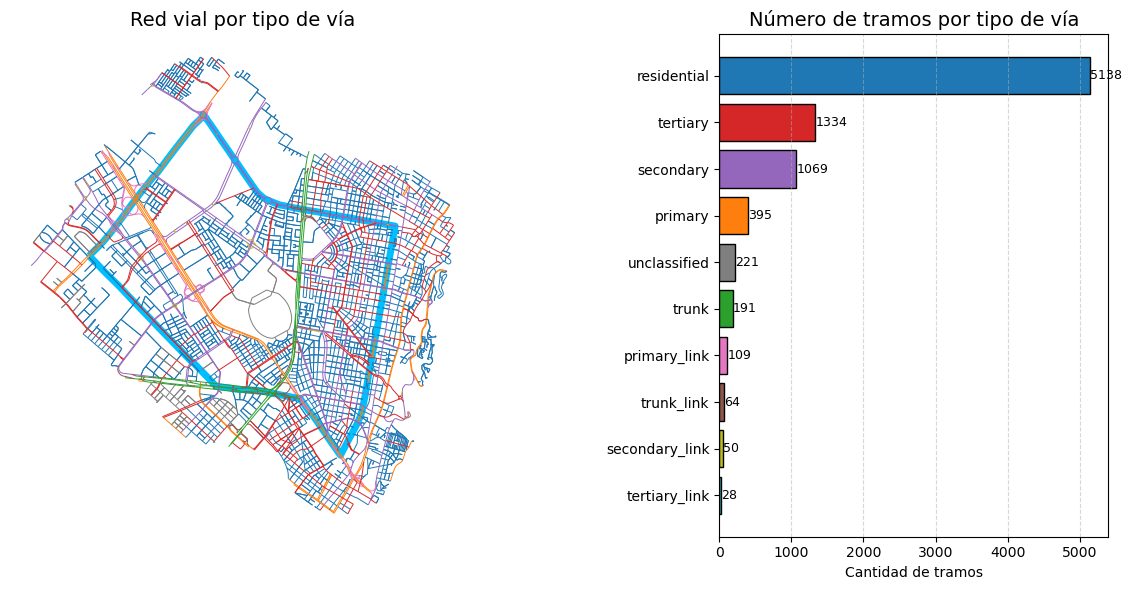

In [36]:
# Generar colormap y colores únicos para cada tipo de vía
tipos_via = edges["highway"].unique()
cmap_base = plt.get_cmap("tab20")
colors = {tipo: mcolors.to_hex(cmap_base(i / len(tipos_via))) for i, tipo in enumerate(tipos_via)}

# 2. Preparar conteo de tramos
conteo_vias = edges["highway"].value_counts().sort_values(ascending=True)
colores_barras = [colors.get(tipo, "#999999") for tipo in conteo_vias.index]

# 3. Crear figura con subplots (mapa + gráfico)
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])

# === Subplot 1: Mapa ===
ax0 = fig.add_subplot(gs[0])
for tipo, group in edges.groupby("highway"):
    group.plot(ax=ax0, linewidth=0.7, edgecolor=colors.get(tipo, "gray"))

# Límite de Teusaquillo en color diferenciado (azul claro)
gdf_localidad = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia")
gdf_localidad.plot(ax=ax0, facecolor="none", edgecolor="deepskyblue", linewidth=5)

ax0.set_title("Red vial por tipo de vía", fontsize=14)
ax0.axis("off")

# === Subplot 2: Gráfico de barras ===
ax1 = fig.add_subplot(gs[1])
bars = ax1.barh(conteo_vias.index, conteo_vias.values, color=colores_barras, edgecolor="black")

# Añadir valores en las barras
for bar in bars:
    ancho = bar.get_width()
    ax1.text(ancho + 1, bar.get_y() + bar.get_height()/2, str(int(ancho)), va='center', fontsize=9)

ax1.set_title("Número de tramos por tipo de vía", fontsize=14)
ax1.set_xlabel("Cantidad de tramos")
ax1.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### 1.4. Transformación a un sistema de referencia proyectado (EPSG:3116)

Aunque OSMnx puede reproyectar automáticamente a la zona UTM más adecuada, en este caso se optó por transformar explícitamente el grafo al sistema de coordenadas EPSG:3116 (MAGNA-SIRGAS / Colombia Bogotá), ampliamente utilizado en proyectos urbanos en Colombia.

El uso de un sistema de referencia proyectado permite que las distancias se expresen en metros en lugar de grados, lo cual es esencial para análisis como el cálculo de rutas más cortas, tiempos de viaje, buffers de accesibilidad, entre otros.

La transformación se realiza utilizando la función `ox.project_graph()`, especificando el CRS destino con el código EPSG correspondiente.


In [38]:
# Reproyectar el grafo manualmente a EPSG:3116
graph_proj = ox.project_graph(graph, to_crs="EPSG:3116")

# Convertir a GeoDataFrames
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj)

# Verificar sistema de referencia
print("CRS proyectado:", nodes_proj.crs)

CRS proyectado: EPSG:3116


## 2. Análisis estadístico de la red vial

Una vez proyectado el grafo, es posible calcular una serie de estadísticas estructurales sobre la red vial utilizando la función `ox.basic_stats()`, que resume propiedades clave como:

- Número de nodos y aristas
- Longitud total y promedio de calles
- Densidad de intersecciones
- Complejidad estructural de la red (índices como `circuity` o `self_loop_proportion`)

### 2.1. Envolvente convexa

Inicialmente, estos cálculos no incorporan el área física cubierta por la red. Para calcular métricas de **densidad (nodos/km², intersecciones/km², etc.)**, es necesario estimar dicha área. OSMnx no lo hace automáticamente, pero puede resolverse fácilmente calculando la **envolvente convexa** (convex hull) de todos los tramos viales.

Una vez calculada esta geometría, su área se pasa como argumento a `ox.basic_stats(graph, area=...)`, lo que permite obtener métricas más robustas y comparables espacialmente.

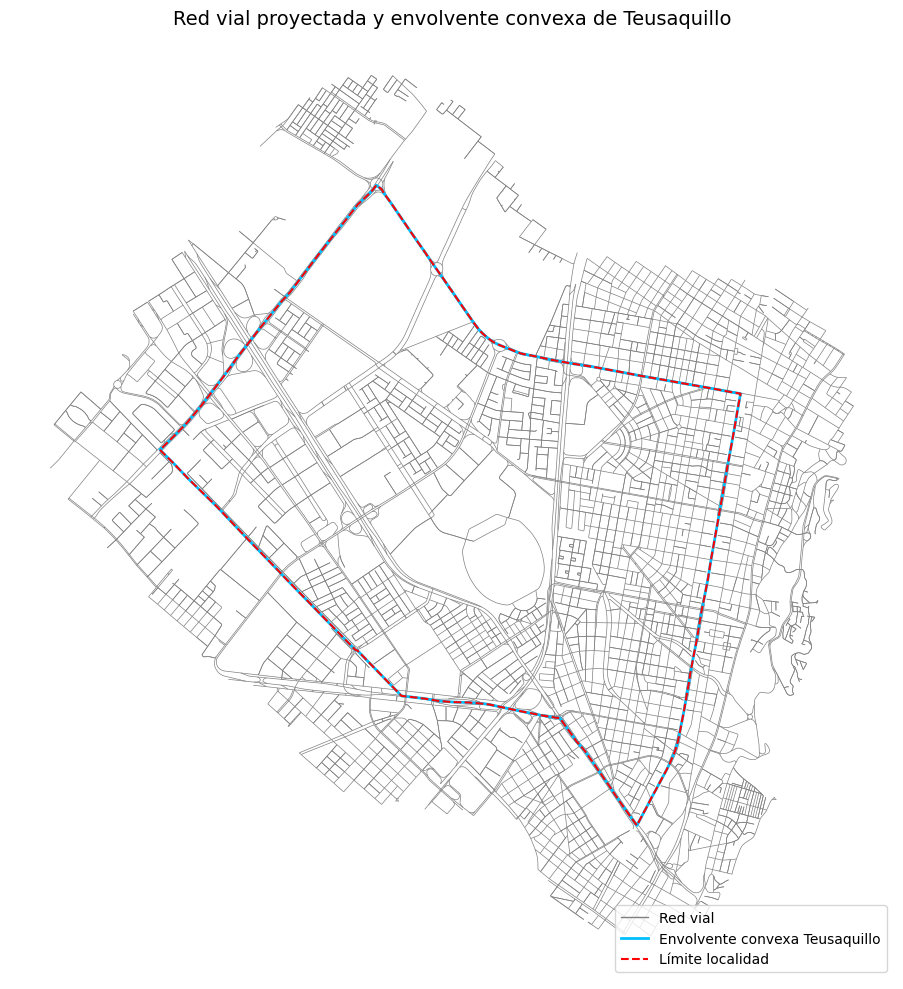

In [61]:
# Obtener geometría proyectada de Teusaquillo
gdf_teusa_proj = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia").to_crs(edges_proj.crs)

# Calcular envolvente convexa y recortarla al límite real
convex_hull = edges_proj.geometry.union_all().convex_hull
convex_hull_clipped = convex_hull.intersection(gdf_teusa_proj.geometry.iloc[0])

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar red vial
edges_proj.plot(ax=ax, linewidth=0.5, edgecolor="gray", zorder=1)

# Dibujar envolvente convexa recortada
if convex_hull_clipped.geom_type == "Polygon":
    ax.plot(*convex_hull_clipped.exterior.xy, color="deepskyblue", linewidth=2, label="Envolvente convexa", zorder=2)
elif convex_hull_clipped.geom_type == "MultiPolygon":
    for poly in convex_hull_clipped:
        ax.plot(*poly.exterior.xy, color="deepskyblue", linewidth=2, zorder=2)

# Dibujar límite de Teusaquillo 
gdf_teusa_proj.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5, linestyle="--", label="Límite localidad", zorder=3)

# Crear leyenda
legend_elements = [
    Line2D([0], [0], color='gray', lw=1, label='Red vial'),
    Line2D([0], [0], color='deepskyblue', lw=2, label='Envolvente convexa Teusaquillo'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.5, label='Límite localidad')
]
ax.legend(handles=legend_elements, loc="lower right")

# Título y visual
ax.set_title("Red vial proyectada y envolvente convexa de Teusaquillo", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [73]:
# Obtener límite real de Teusaquillo
gdf_teusa = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia")

# Descargar grafo restringido al polígono oficial
graph = ox.graph_from_polygon(gdf_teusa.geometry.iloc[0], network_type='drive')

# Proyectar a EPSG:3116
graph_proj = ox.project_graph(graph, to_crs="EPSG:3116")

# Reproyectar el polígono también
gdf_teusa_proj = gdf_teusa.to_crs("EPSG:3116")

# Calcular área real del límite
area_teusa = gdf_teusa_proj.geometry.area.iloc[0]
print(f"Área de Teusaquillo (m²): {area_teusa:,.2f}")

# Estadísticas ajustadas al área real de la localidad
stats_area = ox.basic_stats(graph_proj, area=area_teusa)
print("Estadísticas ajustadas por área real de Teusaquillo:")
print(stats_area)

Área de Teusaquillo (m²): 14,213,035.20
Estadísticas ajustadas por área real de Teusaquillo:
{'n': 1932, 'm': 4137, 'k_avg': 4.282608695652174, 'edge_length_total': 352843.55873586494, 'edge_length_avg': 85.28971688079888, 'streets_per_node_avg': 3.244824016563147, 'streets_per_node_counts': {0: 0, 1: 97, 2: 7, 3: 1166, 4: 651, 5: 10, 6: 1}, 'streets_per_node_proportions': {0: 0.0, 1: 0.05020703933747412, 2: 0.0036231884057971015, 3: 0.6035196687370601, 4: 0.33695652173913043, 5: 0.005175983436853002, 6: 0.0005175983436853002}, 'intersection_count': 1835, 'street_length_total': 267322.6265294007, 'street_segment_count': 3100, 'street_length_avg': 86.23310533206474, 'circuity_avg': 1.0333082041863377, 'self_loop_proportion': 0.0, 'node_density_km': np.float64(135.93155671224292), 'intersection_density_km': np.float64(129.10683569718722), 'edge_density_km': np.float64(24825.348972491633), 'street_density_km': np.float64(18808.271619330724)}


> **Observación metodológica**
>
> Para el cálculo de las estadísticas topológicas y métricas de densidad de la red vial, se utilizó el **límite oficial de la localidad de Teusaquillo**, sin aplicar buffers ni envolventes convexas. Esta decisión metodológica responde a la necesidad de garantizar que los resultados representen **exclusivamente la morfología vial interna** de la localidad, evitando la sobreestimación de variables clave como el número de nodos, aristas, longitud total de calles o número de intersecciones.
>
> El uso de buffers o envolventes convexas, si bien puede ser útil en análisis regionales o para asegurar continuidad geométrica, **incluye porciones de red externa** que no pertenecen administrativamente a Teusaquillo. Esto puede distorsionar las métricas de conectividad y densidad urbana, afectando la validez del análisis comparativo entre localidades o unidades espaciales normalizadas.
>
> Por tanto, todas las estadísticas presentadas a continuación están **espacialmente restringidas al área real de Teusaquillo**, según la delimitación oficial del Distrito Capital de Bogotá.

### 2.2 Estadísticas básicas y análisis de densidad vial

Tras recortar la red vial al límite real de Teusaquillo y proyectarla al sistema EPSG:3116, se calcularon las siguientes estadísticas clave con `ox.basic_stats()`:

- **Nodos (`n`)**: 1932  
- **Aristas (`m`)**: 4137  
- **Longitud total de calles**: 267,322.63 m  
- **Longitud promedio por segmento**: 86.23 m  
- **Número de intersecciones**: 1835  
- **Calles por nodo (promedio)**: 3.24  
- **Proporción de auto-bucles**: 0.0  
- **Índice de *circuity* promedio**: 1.03  

Al considerar el área oficial de la localidad de Teusaquillo, equivalente a **14.21 km²**, se obtuvieron los siguientes indicadores de densidad:

| Indicador                       | Valor estimado                  |
|--------------------------------|---------------------------------|
| Densidad de nodos              | 135.93 nodos/km²                |
| Densidad de intersecciones     | 129.13 inters/km²               |
| Densidad de aristas            | 24,825.39 m/km² (≈24.83 km/km²) |
| Densidad de calles reales      | 18,888.27 m/km² (≈18.89 km/km²) |

Estas cifras reflejan un entramado vial **moderadamente denso y bien conectado**, característico de una centralidad urbana establecida. La longitud promedio de los segmentos cercana a 86 metros, y la alta proporción de intersecciones por unidad de superficie refuerzan esta lectura de alta conectividad local.

### 2.3 Composición y jerarquía vial: análisis por tipo de calle

La red vial urbana se compone de diferentes tipos de calles que cumplen funciones específicas dentro del tejido urbano. A partir del atributo `highway` del conjunto de datos de OSM, se calcularon las longitudes totales asociadas a cada clase de vía.

En el caso de Teusaquillo, la mayor proporción de la red corresponde a calles clasificadas como residenciales, lo cual es esperable en un entorno predominantemente urbano consolidado. Las calles primarias y secundarias complementan esta jerarquía, actuando como vías colectoras y estructurantes del flujo vehicular.

> La longitud total de las vías clasificadas como:
>
> - **residential** es de {glue:}`long_res` km  
> - **primary** es de {glue:}`long_prim` km  
> - **secondary** es de {glue:}`long_sec` km

A continuación, se presentan las cinco clases de vía con mayor longitud total en la red:


#### 2.3.1  Calcular la longitud total de calles por tipo (`highway`)

Algunos tramos viales tienen múltiples etiquetas en la columna `highway`, registradas como listas. Para este análisis se toma únicamente la primera etiqueta como representante del tipo de calle. Posteriormente, se agrupan los tramos según esta categoría y se calcula la longitud total por tipo.

In [75]:
# Convertir listas en la columna 'highway' a strings (tomar solo el primer valor)
edges_proj["highway_clean"] = edges_proj["highway"].apply(lambda x: x[0] if isinstance(x, list) else x)

# Agrupar por tipo limpio y sumar longitud
longitudes_por_tipo = edges_proj.groupby("highway_clean")["length"].sum().sort_values(ascending=False)

# Visualizar las 10 clases más comunes
longitudes_por_tipo.head(10)

highway_clean
residential       421592.250365
tertiary          103441.158411
secondary          97505.849203
primary            56828.034322
trunk              25245.887523
unclassified       25173.123001
primary_link       13344.348095
trunk_link          7042.099084
secondary_link      2377.394720
tertiary_link        754.573971
Name: length, dtype: float64

#### 2.3.2 Visualización del top 5 por longitud total

A continuación se muestra un gráfico de barras con las cinco clases de calle que concentran la mayor longitud total en Teusaquillo.

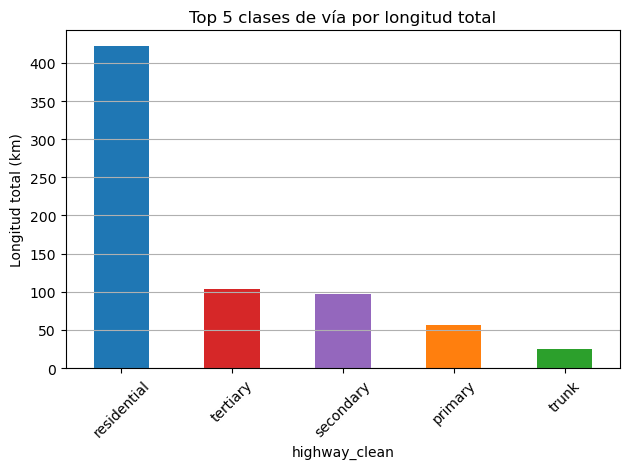

In [81]:
# Colores personalizados por tipo
color_map = {
    "residential": "#1f77b4",
    "primary": "#ff7f0e",
    "secondary": "#9467bd",
    "tertiary": "#d62728",
    "unclassified": "#7f7f7f",
    "trunk": "#2ca02c",
    "living_street": "#800080"
}

# Gráfico
top5.plot(kind="bar", color=top5_colors)
plt.ylabel("Longitud total (km)")
plt.title("Top 5 clases de vía por longitud total")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

#### 2.3.3. Longitud promedio de los segmentos por tipo de calle

Se calcula ahora la longitud promedio de cada tramo de calle, según su clasificación funcional (`highway_clean`). Se resaltan las tres más relevantes.

In [83]:
# Calcular longitud promedio
longitud_media = edges_proj.groupby("highway_clean")["length"].mean().sort_values(ascending=False)

# Ejemplos clave
longitud_media.loc[["residential", "primary", "secondary", "tertiary"]]

highway_clean
residential     82.053766
primary        143.868441
secondary       91.212207
tertiary        77.542098
Name: length, dtype: float64

#### 2.3.4 Generar variables dinámicas para glue

Las siguientes variables insertables permiten incorporar automáticamente los valores numéricos en textos del notebook.

In [93]:
!pip install myst-nb

In [95]:
import myst_nb

# Convertir longitudes de metros a kilómetros y redondear
myst_nb.glue("long_res", round(longitudes_por_tipo["residential"] / 1000, 1))
myst_nb.glue("long_prim", round(longitudes_por_tipo["primary"] / 1000, 1))
myst_nb.glue("long_sec", round(longitudes_por_tipo["secondary"] / 1000, 1))
myst_nb.glue("long_sec", round(longitudes_por_tipo["tertiary"] / 1000, 1))

np.float64(421.6)

np.float64(56.8)

np.float64(97.5)

np.float64(103.4)

#### 2.3.5 Interpretación del patrón vial

> La longitud total de las vías clasificadas como:
>
> - **Recidencial** es de 421.6 km  
> - **Primaria** es de 56.8 km  
> - **Secundaria** es de 97.5 km
> - **Terciaria** es de 103.4 km

Estos resultados evidencian que la red vial de Teusaquillo está fuertemente dominada por calles residenciales, que representan el entramado más fino y extenso de la localidad. Las calles primarias y secundarias, aunque significativamente menos extensas, cumplen una función estructurante en la movilidad interlocal, actuando como ejes de conexión y distribución vehicular de mayor jerarquía.